# Infinite diffuse plane
This notebook performs the simulation of a single diffuse reflection on a plane from a point source to a point receiver.

The ratio between the computed diffuse energy and the energy of a specular reflection is computed and compared to the results put forth by Svensson and Savioja, 2020.

In [14]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from utils.fig_formatting import create_fig, export_fig
%matplotlib inline

writepath = os.path.join(os.getcwd(),"resources","user")

## Simulation

define function to run simulation and evaluate diffuse to specular energy ratio

**NOTE:** the simulations are computationally demanding and can take a long time to run. To see just the final plots, these steps can be skipped (go to "Plot" section)

In [15]:
def run_energy_diff_specular_ratio(
        width, length, patch_size, source, receiver):
    """
    Calculate the ratio of diffuse to specular energy for an plane.
    The plane is located in the x-y plane. Its center is at (0, 0, 0).

    Parameters
    ----------
    width : float
        Width of the plane.
    length : float
        length of the plane.
    patch_size : float
        Size of the patches.
    source : pf.Coordinates
        Position of the source.
    receiver : pf.Coordinates
        Position of the receiver in cartesian.

    Returns
    -------
    ratio : float
        Ratio of diffuse to specular energy.
    """
    # simulation parameters
    source_is = source.copy()
    source_is.z *= -1
    reflection_len =  (receiver - source_is).radius[0]
    speed_of_sound = 343
    sampling_rate = 1
    etc_duration = reflection_len/speed_of_sound
    etc_duration=1

    plane = sp.geometry.Polygon(
            [[-width/2, -length/2, 0],
             [width/2, -length/2, 0],
             [width/2, length/2, 0],
             [-width/2, length/2, 0]],
            [1, 0, 0], [0, 0, 1])

    # Geometry loading
    radi = sp.DirectionalRadiosityFast.from_polygon(
        [plane], patch_size)

    # scattering definition and assignment (perfectly diffuse)
    brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
    brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(1, [100]),
        pf.FrequencyData(0, [100]),
    )
    radi.set_wall_brdf(
        np.arange(1), brdf, brdf_sources, brdf_receivers)

    # set air absorption to 0
    radi.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies))

    # initialize source energy at each patch
    radi.init_source_energy(source)

    # gather energy at each patch
    radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=1/sampling_rate,
        etc_duration=etc_duration,
        max_reflection_order=0)

    # collect diffusely reflected energy at receiver position
    I_diffuse = radi.collect_energy_receiver_mono(receiver)

    # analytical solution for specular reflection
    I_specular = 1/(4*np.pi*reflection_len**2)

    # return diffuse to specular energy ratio
    return np.sum(I_diffuse.time)/I_specular


# run very simple simulation to cache main methods
_=run_energy_diff_specular_ratio(
        1, 1, 1, pf.Coordinates(0, 0, 2, weights=1),
        pf.Coordinates(0, 0, 2, weights=1))

Set up simulation settings

In [16]:
# "infinite" plane dimensions
width=30
depth=30

# patch sizes
patch_sizes = np.array([5, 2, 1, .5])

# range of theta angles for special case (c)
theta_deg = np.arange(15,90,15)
theta = np.deg2rad(theta_deg)

Prepare output dataframe

In [17]:
col_names = ["patch_size",
             "col_raw", "col_abs","col_rel",
             "dif_raw", "dif_abs","dif_rel"]

for th in theta_deg:
    col_names.append("var_raw_"+f'{th}')
    col_names.append("var_abs_"+f'{th}')
    col_names.append("var_rel_"+f'{th}')
    col_names.append("var_abs_"+f'{th}')

df = pd.DataFrame(columns=col_names)
df["patch_size"]=patch_sizes

### Special case (a): colocated source and receiver

In [18]:
ratio_a=[]

# define source and receiver locations
source = pf.Coordinates(0, 0, 2, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)

# run simulation and store result for all patch sizes l
for patch_size in patch_sizes:
    r = run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver)
    ratio_a.append(r)

# store ratio, absolute error and relative error (in %)
df["col_raw"] = ratio_a
df["col_abs"] = 2-np.array(ratio_a)
df["col_rel"] = 100*(2-np.array(ratio_a))/2

### Special case (b): source and receiver aligned with plane normal

In [19]:
err_b = []
ratio_b=[]

# source and receiver at different heights
source = pf.Coordinates(0, 0, 3, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)

# run simulation and store result for all patch sizes l
for patch_size in patch_sizes:
    r = run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver)
    ratio_b.append(r)

# store ratio, absolute error and relative error (in %)
df["dif_raw"] = ratio_b
df["dif_abs"] = 2-np.array(ratio_b)
df["dif_rel"] = 100*(2-np.array(ratio_b))/2

### Special case (c): source and receiver at same height

In [20]:
# for each angle (determining horizontal distance)
for i, th in enumerate(theta):
    # set source and receiver position
    source = pf.Coordinates.from_spherical_colatitude(
        0, th, 2/np.cos(th), weights=1)
    receiver = pf.Coordinates.from_spherical_colatitude(
        np.pi, th, 2/np.cos(th), weights=1)

    ratio3 = []
    w = source.cartesian[0][0]

    # for each patch size l
    for patch_size in patch_sizes:
        # make plane larger in width
        # ensures source and receiver's horizontal distance to edges
        # is at least 15
        ww = 2*patch_size*np.ceil(w/patch_size)

        # run simulation
        r = run_energy_diff_specular_ratio(
            width+ww, depth, patch_size, source, receiver)
        ratio3.append(r)


    # store ratio, absolute error and relative error (in %)
    df["var_raw_"+f"{theta_deg[i]}"] = ratio3
    df["var_abs_"+f"{theta_deg[i]}"] = 2*np.cos(th)-np.array(ratio3)
    df["var_rel_"+f"{theta_deg[i]}"] = 100*(2*np.cos(th) -
                                            np.array(ratio3))/(2*np.cos(th))


### Write results to file

In [21]:
df.to_csv(os.path.join(writepath,"inf_plane_data.csv"))

watermark

In [22]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.1.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

matplotlib: 3.10.1
pandas    : 2.3.0
pyfar     : 0.7.3
sparrowpy : 0.1.0
ipykernel : 6.29.5
debugpy   : 1.8.14
numpy     : 1.26.4



## Plot

Select source and load data

In [ ]:
###################################################
#### SET "True" TO LOAD YOUR OWN GENERATED DATA
#### "False" TO LOAD THE DATA FROM THE PAPER
self_data=False
###################################################

if self_data:
    sub_dir="user"
else:
    sub_dir="paper"

basepath = os.path.join(os.getcwd(),"resources",sub_dir)
dat = pd.read_csv(os.path.join(basepath,"inf_plane_data.csv"))

Plot different special cases as a function of *l/h*

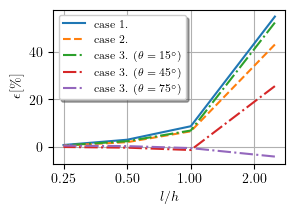

In [28]:
num_patches = (50/dat["patch_size"][:]**2)
patch_ratio = dat["patch_size"][:]/2
psize = np.array(dat["patch_size"][:])


# relative error as a function of patch size
f,a = create_fig(figtype="stubby")
plt.semilogx(patch_ratio[:],dat["col_rel"][:],'-')
plt.semilogx(patch_ratio[:],dat["dif_rel"][:],'--')
plt.semilogx(patch_ratio[:],dat["var_rel_15"][:],'-.')
plt.semilogx(patch_ratio[:],dat["var_rel_45"][:],'-.')
plt.semilogx(patch_ratio[:],dat["var_rel_75"][:],'-.')

plt.ylabel('$\epsilon [\%]$')
plt.xlabel("$ l/h $")
a.xaxis.set_minor_locator(mticker.LogLocator())
a.xaxis.set_major_formatter(mticker.ScalarFormatter())
a.set_xticks([.25,.5,1,2])
plt.legend(["case 1. ","case 2.",
            "case 3. ($\\theta=15^{\circ}$)",
            "case 3. ($\\theta=45^{\circ}$)",
            "case 3. ($\\theta=75^{\circ}$)"],fontsize=8, shadow=True)
plt.show()
export_fig(f,"Figure6")